In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
import phylovelo as pv
from scipy.stats import spearmanr
from Bio import Phylo
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
import scvelo as scv
import loompy

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plt.rcParams['font.size']=12
data_path = '/data3/wangkun/phylovelo_datasets/emt/'

In [4]:
adata = scv.read(data_path+"combined.loom",cache=False)
sample1 = pd.read_csv(data_path+"scRNA_raw_counts.csv",sep=',',header=0,index_col=0)
sample1_metadata = pd.read_csv(data_path+"scRNA_metadata.csv",sep=',',header=0,index_col=0)
cells = sample1.columns.to_list()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
cells = [i.replace("-1","x").replace("PT_","SRR14436657:").replace("PTab_","SRR14436659:").replace("Met_","SRR14436661:").replace("Liver_","SRR14436663:").replace("Lung_","SRR14436665:").replace("Blood_","SRR14436667:") for i in cells]

In [6]:
sample1_adata = adata[cells,:]
sample1_adata.obs["emt_pseudotime"] = sample1_metadata["pseudotime"].to_list()

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
scv.pp.filter_and_normalize(sample1_adata,min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(sample1_adata,n_pcs=30, n_neighbors=30)  #calculate the first and second order moments
scv.tl.louvain(sample1_adata)
# scv.tl.umap(sample1_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 24837 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
umap = pd.read_csv(data_path+'umap.csv', index_col=0)
sample1_adata.obsm['X_umap'] = umap.loc[sample1_adata.obs_names].to_numpy()

recovering dynamics (using 10/160 cores)


  0%|          | 0/975 [00:00<?, ?gene/s]

    finished (0:01:39) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/160 cores)


  0%|          | 0/601 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


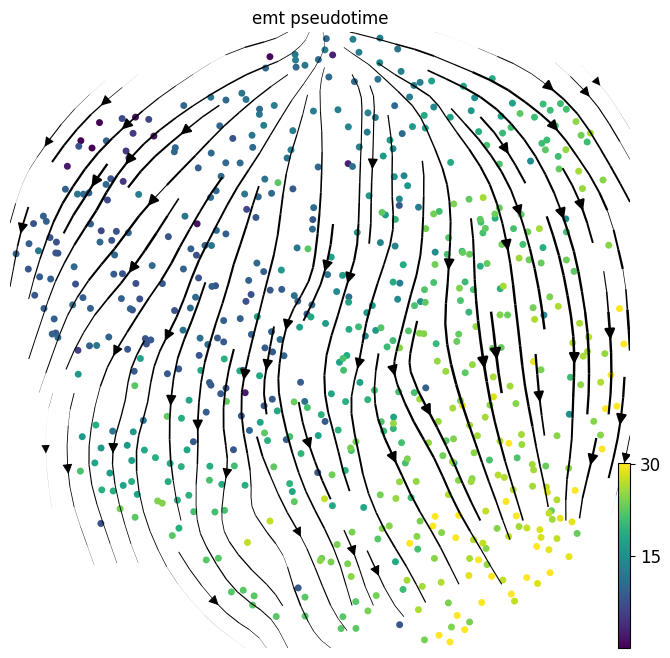

In [9]:
scv.tl.recover_dynamics(sample1_adata,n_jobs=10)
scv.tl.velocity(sample1_adata,mode="dynamical")
scv.tl.velocity_graph(sample1_adata)
scv.pl.velocity_embedding_stream(sample1_adata, basis='X_umap',color="emt_pseudotime",figsize=[8, 8],s=100,alpha=1,density=1,arrow_size=1.5,smooth=1)

In [11]:
x_normed = adata[cells,:]
scv.pp.filter_and_normalize(x_normed, min_shared_counts=10)

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 23686 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [12]:
tree = Phylo.read(data_path+'emt_collapsed.nwk', 'newick')
count = adata[cells,:]

sd = pv.scData()
sd.phylo_tree = tree
sd.cell_names = cells
sd.count = pd.DataFrame(data=count.X.A, columns=count.var_names, index=cells)
sd.Xdr = pd.DataFrame(data=sample1_adata.obsm['X_umap'], index=sample1_adata.obs_names)
sd.Xdr = sd.Xdr.loc[cells]
scv.pp.filter_and_normalize(count, min_shared_counts=10)
sd.x_normed = pd.DataFrame(data=count.X.A, columns=count.var_names, index=cells)


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 23686 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [13]:
name_id_map = pd.DataFrame(data=[f'N{i}' for i in sample1_metadata['index']], index=[re.findall('(?<=\_)[AGCT]+(?=-)', i)[0] for i in sample1_metadata.index])
depths = [sd.phylo_tree.depths()[sd.phylo_tree.find_any(name=name_id_map.loc[re.findall('(?<=\:)[AGCT]+(?=x)', i)[0]].to_numpy()[0])] for i in sd.count.index]

In [14]:
pv.velocity_inference(sd, depths, cutoff=0.95, target='x_normed')
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/8599 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

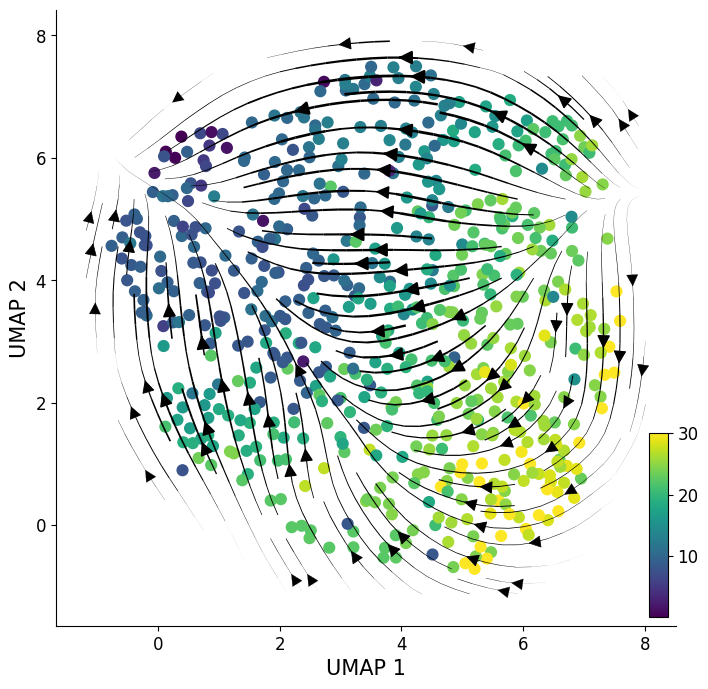

In [15]:
fig, ax = plt.subplots()
scatter=ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=60, c=sample1_adata.obs["emt_pseudotime"])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, radius=0.8, lw_coef=3000, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')

# plt.savefig('./figures/EMT/EMT_stream.pdf', dpi='figure', format='pdf')

In [16]:
sd = pv.calc_phylo_pseudotime(sd, n_neighbors=30)

  0%|          | 0/600 [00:00<?, ?it/s]

In [17]:
scv.tl.latent_time(sample1_adata)

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


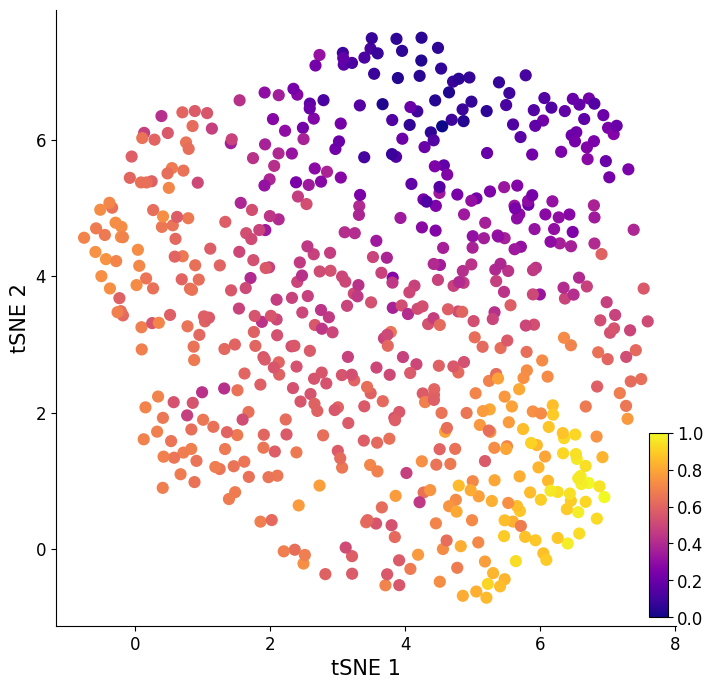

In [18]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(8,8)
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=60, c=sample1_adata.obs["latent_time"],cmap='plasma')
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')

# plt.savefig('./figures/EMT/latent_time.pdf', dpi='figure', format='pdf')

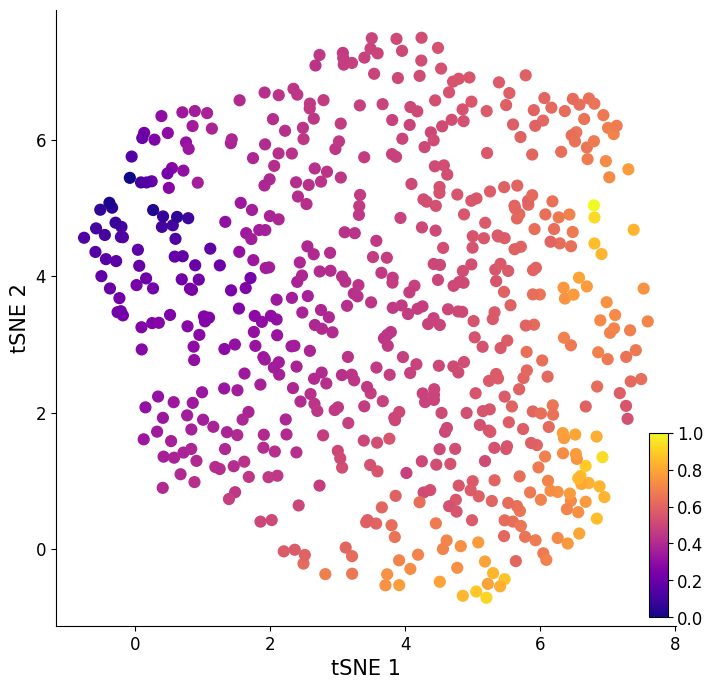

In [19]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(8,8)
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=60, c=sd.phylo_pseudotime,cmap='plasma')
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')

# plt.savefig('./figures/EMT/phylo_pseudotime.pdf', dpi='figure', format='pdf')

In [21]:
from copy import deepcopy
sd_shuffle = deepcopy(sd)
np.random.shuffle(depths)
pv.velocity_inference(sd_shuffle, depths, cutoff=0.95, target='x_normed')
v_megs = pd.DataFrame(data=sd_shuffle.velocity, index=sd_shuffle.x_normed.columns, columns=['velocity']).loc[sd_shuffle.megs]
v_megs['p_value']=sd_shuffle.pvals.T
v_megs['q_value']=sd_shuffle.qvals.T
v_megs.to_csv('./megs/KPCY_shuffle.csv')

  0%|          | 0/8599 [00:00<?, ?it/s]

In [33]:
import numpy as np
from scipy.stats import pearsonr

def corr_plot(x, y, ax):

    a, b = np.polyfit(x, y, deg=1)
    y_est = a * np.linspace(min(x),max(x),60) + b

    # fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(x, y, alpha=0.4, s=70)
    ax.plot(np.linspace(min(x),max(x),60), y_est, '-', c='k')
    # ax.set_xlabel('Velocity Embryo2')
    # ax.set_ylabel('Velocity Embryo3')
    r, pval = pearsonr(x, y)
    ax.text(min(x)*1, max(y), r"Pearson $r$={:.2g}".format(r), fontsize=10)
    try:
        ax.text(min(x)*1, max(y)-(max(y)-min(y))*0.1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=10)
    except:
        ax.text(min(x)*1, max(y)-(max(y)-min(y))*0.1, r'$P={:.2f}$'.format(pval), fontsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

In [28]:
import scanpy as sc
import anndata as ad
adata = ad.AnnData(sd.count)
adata.var_names_make_unique()
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2','USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']
g2m_genes= ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
s_genes = [i.lower().capitalize() for i in s_genes]
g2m_genes = [i.lower().capitalize() for i in g2m_genes]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Text(0.5, 0, 'G2M score')

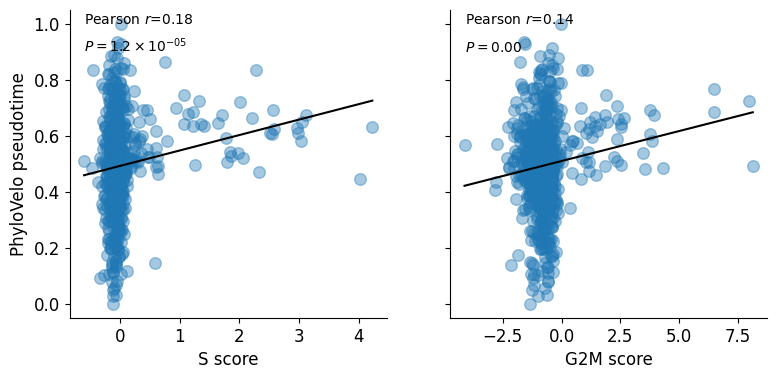

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharey=True)
corr_plot(adata[sd.count.index].obs['S_score'], sd.phylo_pseudotime, ax[0])
corr_plot(adata[sd.count.index].obs['G2M_score'], sd.phylo_pseudotime, ax[1])
ax[0].set_ylabel('PhyloVelo pseudotime')
ax[0].set_xlabel('S score')
ax[1].set_xlabel('G2M score')

Text(0.5, 0, 'G2M score')

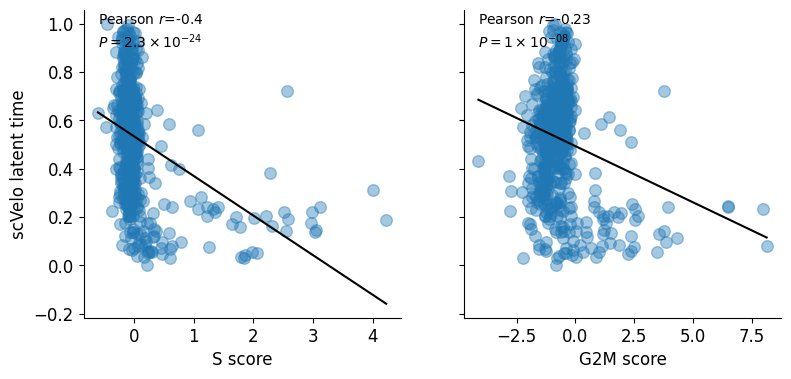

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharey=True)
corr_plot(adata[sd.count.index].obs['S_score'], sample1_adata[sd.count.index].obs['latent_time'], ax[0])
corr_plot(adata[sd.count.index].obs['G2M_score'], sample1_adata[sd.count.index].obs['latent_time'], ax[1])
ax[0].set_ylabel('scVelo latent time')
ax[0].set_xlabel('S score')
ax[1].set_xlabel('G2M score')

In [ ]:

x = sample1_adata.obs["emt_pseudotime"]
y = sd.phylo_pseudotime

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(0,30,60) + b

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(0,30,60), y_est, '-', c='k')
ax.set_xlabel('EMT pseudotime', fontsize=17)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
# ax.text(0, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(0, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(0, 0.91, r'$p={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# plt.savefig('./figures/EMT/phylopseudotime_cmp.pdf', dpi='figure', format='pdf')


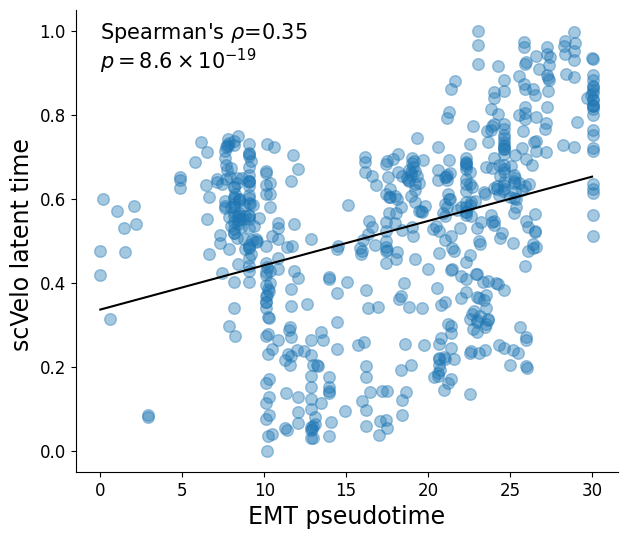

In [39]:

x = sample1_adata.obs["emt_pseudotime"]
y = sample1_adata.obs.latent_time

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(0,30,60) + b

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(0,30,60), y_est, '-', c='k')
ax.set_xlabel('EMT pseudotime', fontsize=17)
ax.set_ylabel('scVelo latent time ', fontsize=17)
rho, pval = spearmanr(x, y)
ax.text(0, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(0, 0.91, r'$p={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# plt.savefig('./figures/EMT/latenttime_cmp.pdf', dpi='figure', format='pdf')


In [617]:
from sklearn.preprocessing import scale
import seaborn as sns

gene_vel_map = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns)
corrs = []
genelist = []
for i in list(gene_vel_map.index[sd.velocity!=0]):
    genelist.append(i)
    x = np.array(depths)
    y = sd.x_normed[i]
    corrs.append(spearmanr(x,y)[0])
corrs = np.array(corrs)
genelist = np.array(genelist)

genes1 = genelist[corrs>0][np.argsort(scale(sd.x_normed[genes1], axis=0).sum(0))]
genes2 = genelist[corrs<0][np.argsort(scale(sd.x_normed[genes2], axis=0).sum(0))]
genes1 = genes1[::-1]


genetraj1 = []
for i in genes1:
    genetraj1.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj1 = np.array(genetraj1)
# genetraj1 = np.log(1+genetraj1)
# genetraj1 = (genetraj1.T / np.max(genetraj1, axis=1)).T

genetraj2 = []
for i in genes2:
    genetraj2.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj2 = np.array(genetraj2)
# genetraj2 = np.log(1+genetraj2)
# genetraj2 = (genetraj2.T / np.max(genetraj2, axis=1)).T

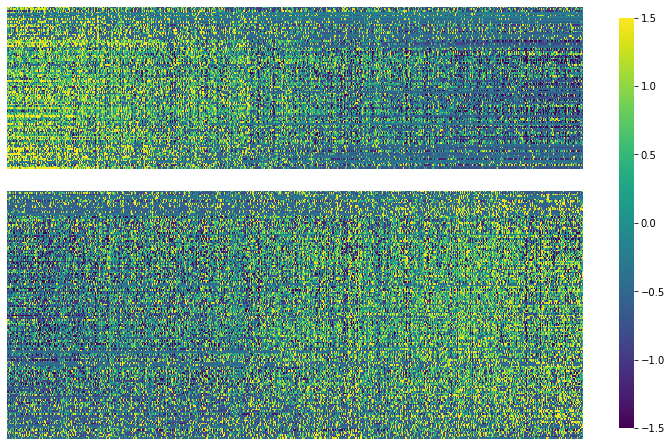

In [618]:
fig = plt.figure(figsize=(10, 6))
h1 = len(genes1)/(len(genes1)+len(genes2))
h2 = len(genes2)/(len(genes1)+len(genes2))
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.02,0.95])

ax1 = sns.heatmap(genetraj1, cmap='viridis', ax=ax1, cbar_ax=ax3,vmax=1.5, vmin=-1.5, xticklabels=False, yticklabels='')
ax2 = sns.heatmap(genetraj2[::-1], cmap='viridis', ax=ax2, cbar=False,vmax=1.5, vmin=-1.5, xticklabels=False, yticklabels='')

plt.savefig('./figures/EMT/heatmap_full_phylopseudotime.pdf', dpi='figure', format='pdf')

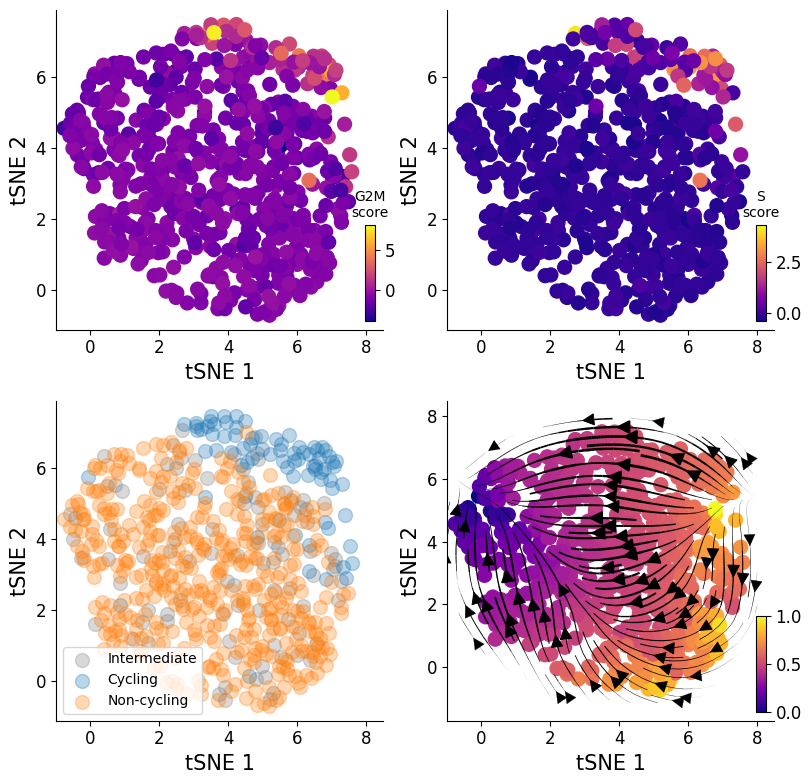

In [65]:
import scanpy as sc
import anndata as ad
adata = ad.AnnData(sd.count)
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2','USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']
g2m_genes= ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
s_genes = [i.lower().capitalize() for i in s_genes]
g2m_genes = [i.lower().capitalize() for i in g2m_genes]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

fig, ax = plt.subplots(2, 2, figsize=(8,8))
scatter=ax[0][0].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], s=100, c=adata.obs['G2M_score'],cmap='plasma')
ax[0][0].set_xlabel('tSNE 1', fontsize=15)
ax[0][0].set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax[0][0], width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
plt.title('G2M\nscore', fontsize=10)


scatter=ax[0][1].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], s=100, c=adata.obs['S_score'],cmap='plasma')
ax[0][1].set_xlabel('tSNE 1', fontsize=15)
ax[0][1].set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax[0][1], width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
plt.title('S\nscore', fontsize=10)

cycling = (adata.obs['G2M_score']>=0.2) | (adata.obs['S_score']>0.2)
non_cycling = (adata.obs['G2M_score']<0) & (adata.obs['S_score']<0)
intermediate = ~(cycling | non_cycling)

ax[1][0].scatter(sd.Xdr.to_numpy()[intermediate, 0], sd.Xdr.to_numpy()[intermediate, 1], s=100, label='Intermediate',c='grey', alpha=0.3)
ax[1][0].scatter(sd.Xdr.to_numpy()[cycling, 0], sd.Xdr.to_numpy()[cycling, 1], s=100, label='Cycling', alpha=0.3)
ax[1][0].scatter(sd.Xdr.to_numpy()[non_cycling, 0], sd.Xdr.to_numpy()[non_cycling, 1], s=100, label='Non-cycling', alpha=0.3)


# ax = pv.velocity_plot(sd.Xdr.to_numpy(), adata.obsm['velocity_tsne'], ax, 'stream', grid_density=25, radius=5, lw_coef=4, arrowsize=1.5)
ax[1][0].set_xlabel('tSNE 1', fontsize=15)
ax[1][0].set_ylabel('tSNE 2', fontsize=15)
ax[1][0].legend(fontsize=10)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)

ax[0][0].set_xlim(-1, 8.5)
ax[0][1].set_xlim(-1, 8.5)
ax[1][0].set_xlim(-1, 8.5)
ax[1][1].set_xlim(-1, 8.5)

# fig, ax = plt.subplots(figsize=(8,8))
scatter = ax[1][1].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], s=100, c=sd.phylo_pseudotime,cmap='plasma')
ax[1][1] = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax[1][1], 'stream',streamdensity=1.2, radius=0.8, lw_coef=3000, arrowsize=2)
ax[1][1].set_xlabel('tSNE 1', fontsize=15)
ax[1][1].set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax[1][1], width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)

plt.tight_layout()

In [66]:
v_megs = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns, columns=['velocity']).loc[sd.megs]
v_megs['p_value']=sd.pvals.T
v_megs['q_value']=sd.qvals.T
v_megs.to_csv('./megs/KPCY.csv')